# Zad 3

Wikipedia Pageview API pozwala pobrać listę najczęściej wyświetlanych artykułów. Sprawdź w dokumentacji jak to zrobić, a następnie:
* Znajdź 10 najczęściej wyświetlanych artykułów z `en.wikipedia.org` w styczniu 2022. Uwaga: na liście znajdą się też strony specjalne, np. `Main_Page`. Należy je manualnie odfiltrować.
* Następnie dla każdego z nich pobierz liczbę wyświetleń dla każdego dnia w 2022. Umieść wszystkie dane w `DataFrame`.
* https://wikitech.wikimedia.org/w/index.php?title=Data_Platform/AQS/Pageviews&oldid=2201533

In [102]:
# import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# For wiki_article_views_daily
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

HEADERS = {"User-Agent": "s24353@pja.edu.pl"}

In [103]:
def wiki_article_views_monthly(year, month):
    url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/{year}/{month}/all-days"

    r = requests.get(url, headers=HEADERS)

    # data = r.json()
    # print(json.dumps(data, indent=4, sort_keys=False))

    return r

r = wiki_article_views_monthly("2022","01")
print(r.url)

https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/2022/01/all-days


In [104]:
df = pd.DataFrame(r.json()['items'][0]['articles'])
df.rename(columns={'views':'views_01_2022'}, inplace=True)
index = df[df.article.str.contains("(Main_Page)|(Special:)|(File:)|(Wikipedia:)|(Portal:)")]
df = df.drop(index.index)

df = df.head(10)

df.set_index('rank', inplace=True)
df

/var/folders/mc/zh86xrrn7bn5z5x4bd29xgp40000gn/T/ipykernel_34537/1235662291.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  index = df[df.article.str.contains("(Main_Page)|(Special:)|(File:)|(Wikipedia:)|(Portal:)")]


,article,views_01_2022
rank,,
3,Bob_Saget,6807825
4,Betty_White,5900462
5,Bible,4488269
6,Spider-Man:_No_Way_Home,4396131
7,Cleopatra,4131379
8,Meat_Loaf,3956170
9,Deaths_in_2022,3926077
10,Eternals_(film),3552382
11,Pushpa:_The_Rise,3482817


In [105]:
def wiki_article_views_daily(article, start_date, end_date):
    url_base = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/"
    url = url_base + f"{article}/daily/{start_date}/{end_date}"

    r = requests.get(url, headers=HEADERS)

    json_data = r.json()['items']
    views_dict = {item['timestamp']: item['views'] for item in json_data}

    return views_dict

for i in range(len(df)):
    article = df.iloc[i]['article']
    views_dict = wiki_article_views_daily(article, "2022010100", "2022123100")

    for timestamp, views in views_dict.items():
        # Convert timestamp to datetime
        date_obj = pd.to_datetime(timestamp, format='%Y%m%d00')
        # Format as string to remove time
        date_str = date_obj.strftime('%Y-%m-%d')

        if date_str not in df.columns:
            df[date_str] = None

        df.at[df.iloc[i].name, date_str] = views

df.head()

,article,views_01_2022,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
rank,,,,,,,,,,,,,,,,,,,,,
3,Bob_Saget,6807825,1373,1592,1542,1371,1453,1723,1858,1832,...,4732,4739,4440,5577,6990,7814,7907,15623,10356,10810
4,Betty_White,5900462,2324929,731824,415959,314401,219322,149166,126057,115318,...,5938,6343,6517,8470,7895,7453,7484,7802,9407,40093
5,Bible,4488269,114312,140451,132842,132668,139882,138741,114085,135005,...,2992,3012,3621,4267,3466,3309,3282,3216,3069,3259
6,Spider-Man:_No_Way_Home,4396131,236963,254276,244848,209216,186352,171332,172743,191240,...,11631,11899,11674,13260,14123,14830,15471,15999,14875,13988
7,Cleopatra,4131379,139383,135655,135304,133493,140245,136906,139608,140807,...,149040,150814,152552,155069,153363,158846,154309,155309,154743,162590


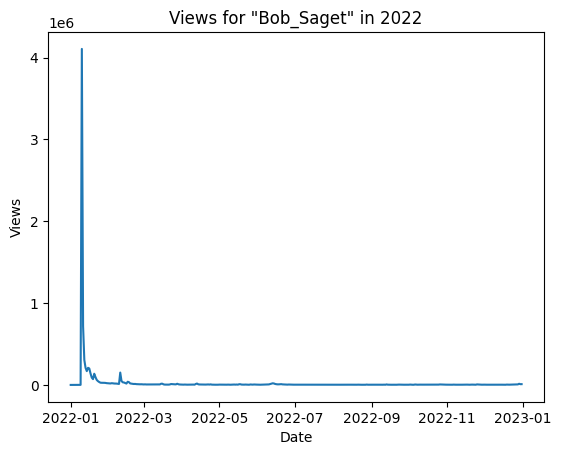

In [106]:
# Get data from the top article
top_article = df.iloc[0]
article_name = top_article['article']
date_columns = [col for col in df.columns if col not in ['article', 'views_01_2022']]
dates_dt = pd.to_datetime(date_columns)
views = [top_article[col] for col in date_columns]

# Plot
plt.plot(dates_dt, views)
plt.title(f'Views for "{article_name}" in 2022')
plt.xlabel('Date')
plt.ylabel('Views')
plt.show()